Atmosphere Tests in Sensitivity Calculator v1
=====
These are tests to investigate the calculation of the atmospheric temperature and its impact on the results. We're testing this in version 1 of the code as this is stable, whereas version 2 is currently in development.

First we set up the calculator, then read in the tables that have been output from the am code. These are the sky temperature and opacity calculated at zenith.

In [19]:
from atlast_sc.calculator import Calculator
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as pl
calculator = Calculator()

from atlast_sc.derived_groups import AtmosphereParams
T_atm_table = np.genfromtxt(AtmosphereParams._T_ATM_PATH)
tau_atm_table = np.genfromtxt(AtmosphereParams._TAU_ATM_PATH)

These tables include values for water column percentiles ranging from 5% to 95%. We will arbitrarily select the one for 25%.

In [55]:
j=2     # For 25% water column

Based on [ALMA memo 602](https://library.nrao.edu/public/memos/alma/main/memo602.pdf), we then calculate the atmospheric temperature as:

$T_{atm}=\frac{T_{sky}(\nu,z=0)}{(1-e^{-\tau_0(\nu)})}$

and from this then calculate $T_{sky}$ at the chosen elevation using:

$T_{sky}(\nu,z)=T_{atm}(1-e^{-\tau_0(\nu)*\sec(z)})$

In [56]:
tskyz0 = T_atm_table[:,j]
tau0 = tau_atm_table[:,j]
tatm = tskyz0/(1-np.exp(-tau0))
elevation = 45*u.deg
zenith = 90*u.deg-elevation
tau = tau0/np.cos(zenith)
transmittance = np.exp(-tau)
tskyznon0 = tatm * (1-transmittance)
# print(tatm)

Plotting this we find that $T_{atm}$ is not constant with frequency.

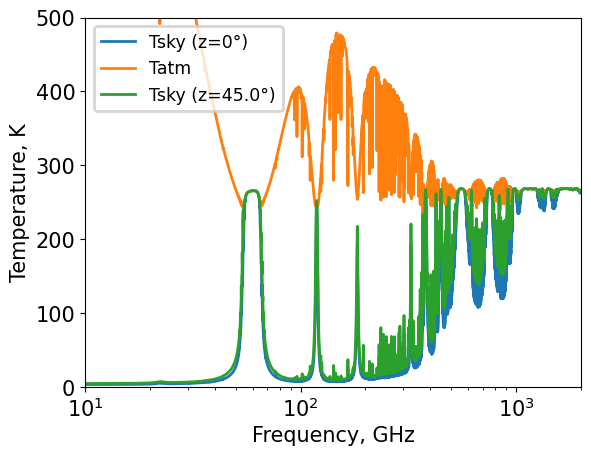

In [57]:
pl.figure()
pl.plot(T_atm_table[:,0], tskyz0,label='Tsky (z=0°)')
pl.plot(T_atm_table[:,0], tatm, label='Tatm')
pl.plot(T_atm_table[:,0], tskyznon0,label='Tsky (z='+str(zenith.value)+'°)')
pl.xscale('log')
pl.xlim(10,2000)
pl.ylim(0, 500)
pl.xlabel('Frequency, GHz')
pl.ylabel('Temperature, K')
pl.legend(prop={'size':'small'},numpoints=1)

Text(0, 0.5, '$(1-e^{-\\tau_0(\\nu)})^{-1}$')

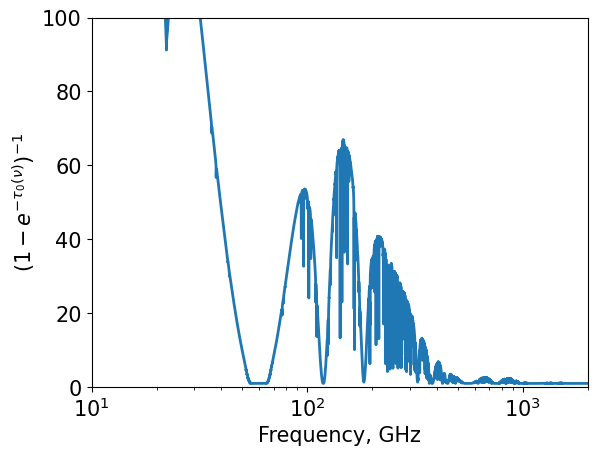

In [58]:
pl.figure()
pl.plot(T_atm_table[:,0], 1/(1-np.exp(-tau_atm_table[:,2])))
#pl.plot(T_atm_table[:,0], (1-np.exp(-tau_atm_table[:,2]/np.cos(45*u.deg))))
#pl.plot(T_atm_table[:,0], (1-np.exp(-tau_atm_table[:,2]/np.cos(45*u.deg)))/(1-np.exp(-tau_atm_table[:,2])))
pl.xscale('log')
pl.xlim(10,2000)
pl.ylim(0,100)
pl.xlabel('Frequency, GHz')
pl.ylabel(r'$(1-e^{-\tau_0(\nu)})^{-1}$')

The large rise at low frequencies is due to the am code including T_CMB by default. This should be removed as our code treats T_CMB separately. It's unclear what causes the rise at other frequencies, although our suspicion is that this simple equation does not properly account for the variations in atmospheric layers.

If we instead use a fixed T_atm, as is done with the TIFUUN and CHAI calculators for instance, then we find that the final result actually isn't all that different.

268.5971


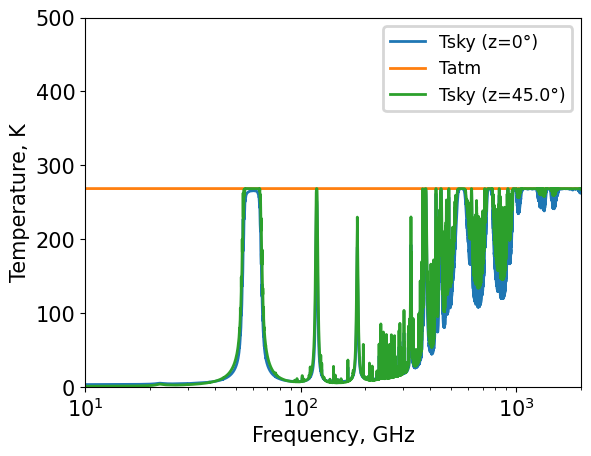

In [59]:
tatmconst=np.max(tskyz0) # setting T_atm to the max of T_sky at zenith
print(tatmconst)

pl.figure()
pl.plot(T_atm_table[:,0], tskyz0,label='Tsky (z=0°)')
pl.plot(T_atm_table[:,0], np.full_like(tskyz0,tatmconst), label='Tatm')
pl.plot(T_atm_table[:,0], tatmconst* (1-transmittance),label='Tsky (z='+str(zenith.value)+'°)')
pl.xscale('log')
pl.xlim(10,2000)
pl.ylim(0, 500)
pl.xlabel('Frequency, GHz')
pl.ylabel('Temperature, K')
pl.legend(prop={'size':'small'},numpoints=1)

Text(0, 0.5, 'Tsky difference, K')

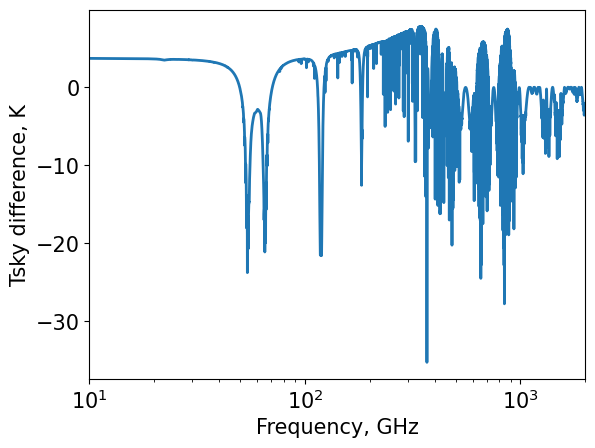

In [73]:
tskyznon0_const_Tatm = tatmconst* (1-transmittance)

# pl.figure()
# pl.plot(T_atm_table[:,0], tskyznon0/tskyznon0_const_Tatm)
# pl.ylim(0.8, 8)
# pl.xscale('log')
# pl.yscale('log')
# pl.xlim(10,2000)

pl.figure()
pl.plot(T_atm_table[:,0], tskyznon0-tskyznon0_const_Tatm)
pl.xscale('log')
pl.xlim(10,2000)
pl.xlabel('Frequency, GHz')
pl.ylabel('Tsky difference, K')


As we can see, the largest differences are around telluric lines.

Calculating the T_sys for both cases to find out the impact.

(-200.0, 20.0)

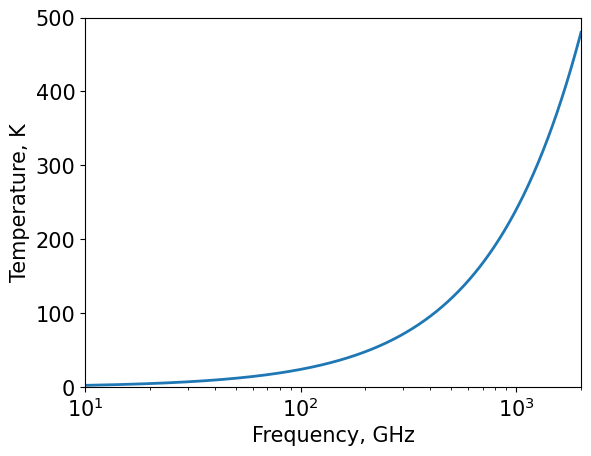

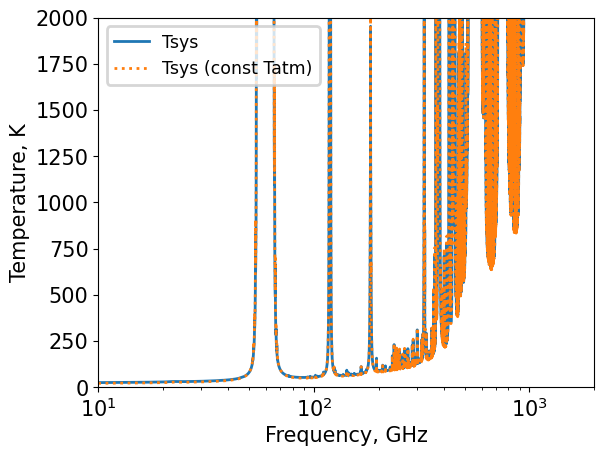

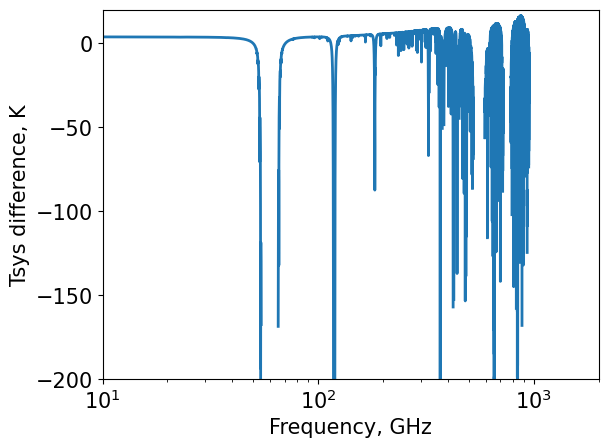

In [74]:
def t_sys(Tsky,Trx,transmittance):
    return 1/(calculator.eta_eff*transmittance)*(Trx + (calculator.eta_eff*(Tsky+calculator.T_cmb.value)) + (1-calculator.eta_eff)*calculator.T_amb.value)

T_rx = (5*const.h*(T_atm_table[:,0]*u.GHz)/const.k_B).to(u.K).value

pl.figure()
pl.plot(T_atm_table[:,0], T_rx,label='T_rx')
#pl.plot(T_atm_table[:,0], np.full_like(tskyz0,tatmconst), label='Tatm')
#pl.plot(T_atm_table[:,0], tatmconst* (1-transmittance),label='Tsky (z='+str(zenith.value)+'°)')
pl.xscale('log')
pl.xlim(10,2000)
pl.ylim(0, 500)
pl.xlabel('Frequency, GHz')
pl.ylabel('Temperature, K')
#pl.legend(prop={'size':'small'},numpoints=1)


tsys = t_sys(tskyznon0, T_rx,transmittance)
tsys_const_Tatm = t_sys(tskyznon0_const_Tatm, T_rx,transmittance)

pl.figure()
pl.plot(T_atm_table[:,0], tsys,label='Tsys')
pl.plot(T_atm_table[:,0], tsys_const_Tatm, label='Tsys (const Tatm)',linestyle=':')
#pl.plot(T_atm_table[:,0], tatmconst* (1-transmittance),label='Tsky (z='+str(zenith.value)+'°)')
pl.xscale('log')
pl.xlim(10,2000)
pl.ylim(0, 2000)
pl.xlabel('Frequency, GHz')
pl.ylabel('Temperature, K')
pl.legend(prop={'size':'small'},numpoints=1)

tsysdiff = tsys-tsys_const_Tatm
tsysdiff[transmittance<0.10] = np.nan # Ignore anything with transmittance less than 10% to get a clearer plot
pl.figure()
pl.plot(T_atm_table[:,0], tsysdiff)
pl.xscale('log')
pl.xlabel('Frequency, GHz')
pl.ylabel('Tsys difference, K')
pl.xlim(10,2000)
pl.ylim(-200, 20)

Repeating this for 50% weather to get a sense of the difference that causes.

Text(0, 0.5, 'Tsky difference, K')

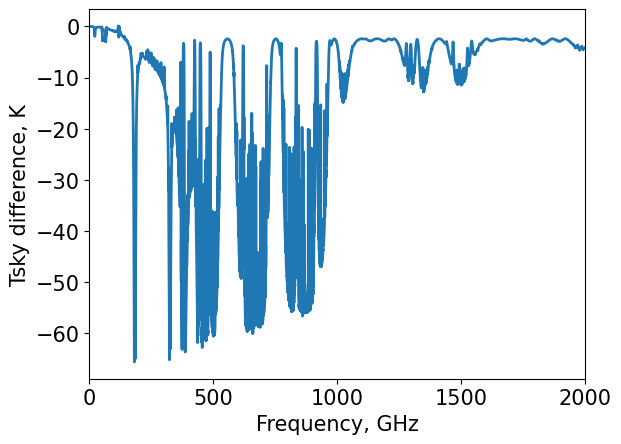

In [75]:
j=3 # 50% water column percentile

tskyz0_50 = T_atm_table[:,j]
tau0_50 = tau_atm_table[:,j]
tatm_50 = tskyz0_50/(1-np.exp(-tau0_50))
elevation_50 = 45*u.deg
zenith_50 = 90*u.deg-elevation_50
tau_50 = tau0_50/np.cos(zenith_50)
transmittance_50 = np.exp(-tau_50)
tskyznon0_50 = tatm_50 * (1-transmittance_50)

# pl.figure()
# pl.plot(T_atm_table[:,0], tskyznon0/tskyznon0_50)
# pl.ylim(0, 2)

pl.figure()
pl.plot(T_atm_table[:,0], tskyznon0-tskyznon0_50)
pl.xlabel('Frequency, GHz')
pl.ylabel('Tsky difference, K')